In [1]:
# mount
import os
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [2]:
PROJECT_PATH = join(ROOT,'My Drive/GGI_school_2025')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from copy import deepcopy
from tqdm import tqdm
import json

# Install packages

In [4]:
## https://corner.readthedocs.io/en/latest/
!pip install corner

In [5]:
## https://lscsoft.docs.ligo.org/bilby/
!pip install bilby
#!pip install gwpy lalsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.9/983.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.6 MB/s eta 0:00:00


In [6]:
import corner
import bilby

# Linear Regression

In [44]:
from scipy.stats import norm

In [63]:
alpha_true = 2.0
beta_true = 0.5

def model(x):
  return alpha_true*x + beta_true

num_obs = 100

sigma_y_noise = 0.25

In [64]:
x_true = np.random.uniform(0,1,num_obs)
y_true = model(x_true)

x_obs = x_true
zero_noise = False
load=True

if zero_noise:
  y_obs = y_true
elif load==True:
  # load data
  x_obs = np.load(PROJECT_PATH+'/data/x_obs.npy')
  y_obs = np.load(PROJECT_PATH+'/data/y_obs.npy')
else:
  y_obs = y_true + np.random.normal(0,sigma_y_noise,num_obs)

Let us assume a linear ansatz
$$
y = \alpha x + \beta
$$

In [10]:
class SimpleGaussianLikelihood(bilby.Likelihood):
    def __init__(self, x_obs, y_obs):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={"alpha": None,"beta": None})
        self.x_obs = x_obs
        self.y_obs = y_obs
        self.sigma_y_noise = sigma_y_noise

    def log_likelihood(self):
        alpha = self.parameters["alpha"]
        beta = self.parameters["beta"]
        ## LINEAR ANSATZ
        y_pred = alpha*self.x_obs + beta
        out = np.sum(norm.logpdf(y_pred,loc=self.y_obs,scale=self.sigma_y_noise))
        return out

In [11]:
likelihood = SimpleGaussianLikelihood(x_obs,y_obs)

In [12]:
priors = dict(
    alpha=bilby.core.prior.Uniform(0, 5, "alpha"),
    beta=bilby.core.prior.Uniform(0, 5, "beta"),
)
priors

{'alpha': Uniform(minimum=0, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None),
 'beta': Uniform(minimum=0, maximum=5, name='beta', latex_label='beta', unit=None, boundary=None)}

In [13]:
outdir = PROJECT_PATH+'/models'
label = 'linear_5k'

In [14]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=5_000,
    outdir=outdir,
    label=label,
)

10:11 bilby INFO    : Running for label 'linear_5k_0noise', output will be saved to '/content/drive/My Drive/GGI_school_2025/models'
10:11 bilby INFO    : Analysis priors:
10:11 bilby INFO    : alpha=Uniform(minimum=0, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None)
10:11 bilby INFO    : beta=Uniform(minimum=0, maximum=5, name='beta', latex_label='beta', unit=None, boundary=None)
10:11 bilby INFO    : Analysis likelihood class: <class '__main__.SimpleGaussianLikelihood'>
10:11 bilby INFO    : Analysis likelihood noise evidence: nan
10:11 bilby INFO    : Single likelihood evaluation took 2.951e-04 s
10:11 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 5000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwarg

1it [00:00, ?it/s]

10:16 bilby INFO    : Written checkpoint file /content/drive/My Drive/GGI_school_2025/models/linear_5k_0noise_resume.pickle
10:16 bilby INFO    : Rejection sampling nested samples to obtain 13207 posterior samples
10:16 bilby INFO    : Sampling time: 0:05:09.836339


10:16 bilby INFO    : Summary of results:
nsamples: 13207
ln_noise_evidence:    nan
ln_evidence: 39.287 +/-  0.049
ln_bayes_factor:    nan +/-  0.049



In [65]:
outdir = PROJECT_PATH+'/models'
label = 'linear_5k'

result_file_name = outdir + '/%s_result.json'%label
with open(result_file_name,'r') as f:
  res = json.load(f)

In [66]:
res.keys()

dict_keys(['label', 'outdir', 'sampler', 'log_evidence', 'log_evidence_err', 'log_noise_evidence', 'log_bayes_factor', 'priors', 'posterior', 'injection_parameters', 'meta_data', 'search_parameter_keys', 'fixed_parameter_keys', 'constraint_parameter_keys', 'sampling_time', 'sampler_kwargs', 'use_ratio', 'information_gain', 'log_likelihood_evaluations', 'log_prior_evaluations', 'num_likelihood_evaluations', 'samples', 'nested_samples', 'parameter_labels', 'parameter_labels_with_unit', 'version'])

In [67]:
res['log_evidence']

-3.7086353958381206

In [68]:
alpha_post = res['posterior']['content']['alpha']
beta_post = res['posterior']['content']['beta']

samples = np.vstack((alpha_post,beta_post)).T
print(samples.shape)

(13580, 2)


In [70]:
## maximum likelihood approxmation
## = ordinary linear least squares

alpha_ml = (np.mean(x_obs*y_obs)-np.mean(x_obs)*np.mean(y_obs))/(np.mean(x_obs**2)-np.mean(x_obs)**2)
beta_ml = np.mean(y_obs)-alpha_ml*np.mean(x_obs)

Gamma = num_obs/(sigma_y_noise)**2*np.matrix([[np.mean(x_obs**2),np.mean(x_obs)],[np.mean(x_obs),1]])
Sigma = np.array(Gamma.I)

samples_ml = np.random.multivariate_normal(mean=np.array([alpha_ml,beta_ml]),cov=Sigma,size=len(samples))

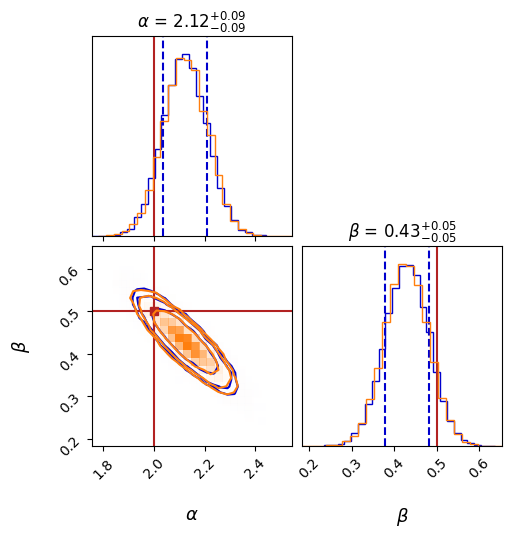

In [71]:
## corner plot of the posterior
## https://matplotlib.org/stable/gallery/color/named_colors.html

labels = [r'$\alpha$',r'$\beta$']
truths = [alpha_true,beta_true]

hist2d_kwargs = {'plot_datapoints':False,'fill_contours':False,
                 'levels':[0.68,0.90,0.95]}

fig = corner.corner(samples,bins=25,color='mediumblue',\
                    truths=truths,truth_color='firebrick',\
                    labels=labels,label_kwargs={'fontsize':13},\
                    quantiles = [0.16,0.84],\
                    show_titles=True,title_quantiles=[0.16,0.5,0.84],\
                    hist_kwargs={'density':True},\
                    **hist2d_kwargs,\
                    )

###'''
corner.corner(samples_ml,bins=25,color='C1',\
              labels=None,fig=fig,\
              hist_kwargs={'density':True},\
              **hist2d_kwargs,\
              )
###'''

plt.savefig(PROJECT_PATH+'/plots/corner_%s.pdf'%label,bbox_inches='tight')
plt.show()

In [72]:
## posterior predictive distribution
X = np.linspace(0,1,100)
yp = []
for sample in samples:
  alpha, beta = sample
  yp.append(alpha*X+beta)
yp = np.array(yp)
ylow, ymean, yhigh = np.quantile(yp,q=[0.05,0.5,0.95],axis=0)

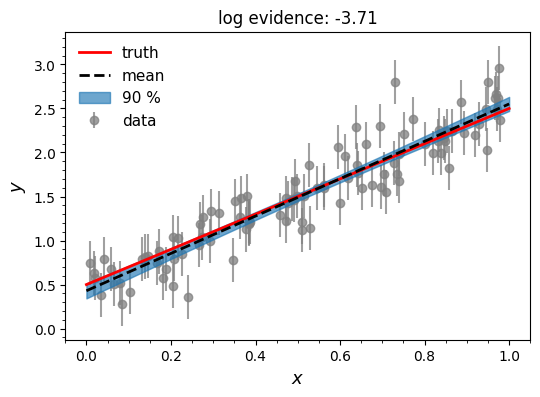

In [73]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.errorbar(x_obs,y_obs,yerr=sigma_y_noise,fmt='o',color='gray',label='data',zorder=-1,alpha=0.75)
axs.plot(X,alpha_true*X+beta_true,color='red',linewidth=2,linestyle='-',label='truth')#,zorder=0)
axs.plot(X,ymean,color='k',linewidth=2,linestyle='--',label='mean')
axs.fill_between(X,ylow,yhigh,color='C0',alpha=0.65,label='90 %')
axs.set_xlabel(r'$x$',fontsize=13)
axs.set_ylabel(r'$y$',fontsize=13)
axs.legend(fontsize=11,frameon=False)
axs.minorticks_on()
axs.set_title('log evidence: %.2f'%res['log_evidence'])
plt.savefig(PROJECT_PATH+'/plots/posterior_%s.pdf'%label,bbox_inches='tight')
plt.show()

Let us now assume that I recover the data with a quadratic ansatz
$$
y = \alpha x^2 + \beta
$$

In [23]:
class SimpleGaussianLikelihood(bilby.Likelihood):
    def __init__(self, x_obs, y_obs):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={"alpha": None,"beta": None})
        self.x_obs = x_obs
        self.y_obs = y_obs
        self.sigma_y_noise = sigma_y_noise

    def log_likelihood(self):
        alpha = self.parameters["alpha"]
        beta = self.parameters["beta"]
        ## QUADRATIC ANSATZ
        y_pred = alpha*self.x_obs**2 + beta
        out = np.sum(norm.logpdf(y_pred,loc=self.y_obs,scale=self.sigma_y_noise))
        return out

In [24]:
likelihood = SimpleGaussianLikelihood(x_obs,y_obs)

In [25]:
priors = dict(
    alpha=bilby.core.prior.Uniform(0, 5, "alpha"),
    beta=bilby.core.prior.Uniform(0, 5, "beta"),
)
priors

{'alpha': Uniform(minimum=0, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None),
 'beta': Uniform(minimum=0, maximum=5, name='beta', latex_label='beta', unit=None, boundary=None)}

In [26]:
outdir = PROJECT_PATH+'/models'
label = 'quadratic_5k'

In [27]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=5_000,
    outdir=outdir,
    label=label,
)

10:20 bilby INFO    : Running for label 'quadratic_5k_0noise', output will be saved to '/content/drive/My Drive/GGI_school_2025/models'
10:20 bilby INFO    : Analysis priors:
10:20 bilby INFO    : alpha=Uniform(minimum=0, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None)
10:20 bilby INFO    : beta=Uniform(minimum=0, maximum=5, name='beta', latex_label='beta', unit=None, boundary=None)
10:20 bilby INFO    : Analysis likelihood class: <class '__main__.SimpleGaussianLikelihood'>
10:20 bilby INFO    : Analysis likelihood noise evidence: nan
10:20 bilby INFO    : Single likelihood evaluation took 1.855e-04 s
10:20 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 5000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kw

1it [00:00, ?it/s]

10:25 bilby INFO    : Written checkpoint file /content/drive/My Drive/GGI_school_2025/models/quadratic_5k_0noise_resume.pickle
10:25 bilby INFO    : Rejection sampling nested samples to obtain 13384 posterior samples
10:25 bilby INFO    : Sampling time: 0:05:13.870158


10:25 bilby INFO    : Summary of results:
nsamples: 13384
ln_noise_evidence:    nan
ln_evidence: 23.565 +/-  0.049
ln_bayes_factor:    nan +/-  0.049



In [74]:
outdir = PROJECT_PATH+'/models'
label = 'quadratic_5k'

result_file_name = outdir + '/%s_result.json'%label
with open(result_file_name,'r') as f:
  res = json.load(f)

In [75]:
alpha_post = res['posterior']['content']['alpha']
beta_post = res['posterior']['content']['beta']

samples = np.vstack((alpha_post,beta_post)).T
print(samples.shape)

(13417, 2)


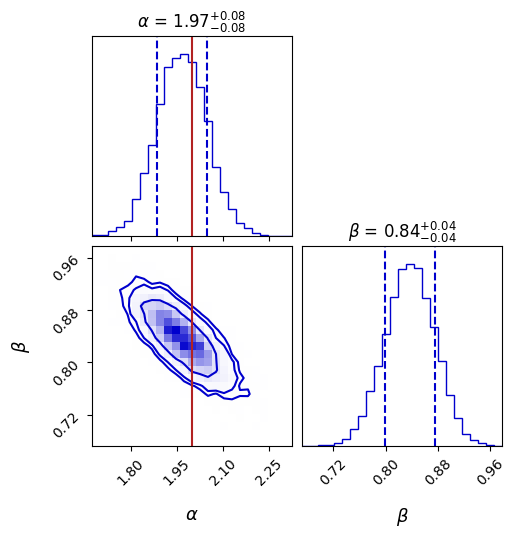

In [76]:
## corner plot of the posterior
## https://matplotlib.org/stable/gallery/color/named_colors.html

labels = [r'$\alpha$',r'$\beta$']
truths = [alpha_true,beta_true]

hist2d_kwargs = {'plot_datapoints':False,'fill_contours':False,
                 'levels':[0.68,0.90,0.95]}

fig = corner.corner(samples,bins=25,color='mediumblue',\
                    truths=truths,truth_color='firebrick',\
                    labels=labels,label_kwargs={'fontsize':13},\
                    quantiles = [0.16,0.84],\
                    show_titles=True,title_quantiles=[0.16,0.5,0.84],\
                    hist_kwargs={'density':True},\
                    **hist2d_kwargs,\
                    )

plt.savefig(PROJECT_PATH+'/plots/corner_%s.pdf'%label,bbox_inches='tight')
plt.show()

In [77]:
## posterior predictive distribution
X = np.linspace(0,1,100)
yp = []
for sample in samples:
  alpha, beta = sample
  yp.append(alpha*X**2+beta)
yp = np.array(yp)
ylow, ymean, yhigh = np.quantile(yp,q=[0.05,0.5,0.95],axis=0)

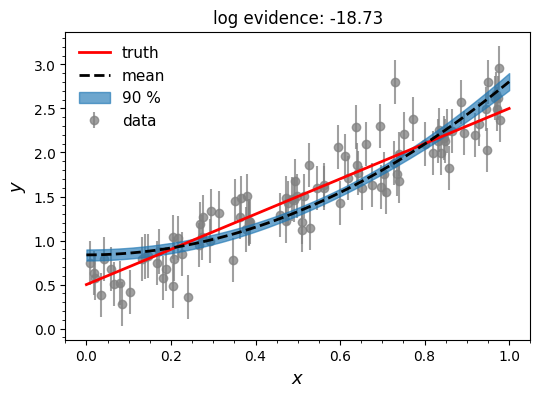

In [78]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.errorbar(x_obs,y_obs,yerr=sigma_y_noise,fmt='o',color='gray',label='data',zorder=-1,alpha=0.75)
axs.plot(X,alpha_true*X+beta_true,color='red',linewidth=2,linestyle='-',label='truth')#,zorder=0)
axs.plot(X,ymean,color='k',linewidth=2,linestyle='--',label='mean')
axs.fill_between(X,ylow,yhigh,color='C0',alpha=0.65,label='90 %')
axs.set_xlabel(r'$x$',fontsize=13)
axs.set_ylabel(r'$y$',fontsize=13)
axs.legend(fontsize=11,frameon=False)
axs.minorticks_on()
axs.set_title('log evidence: %.2f'%res['log_evidence'])
plt.savefig(PROJECT_PATH+'/plots/posterior_%s.pdf'%label,bbox_inches='tight')
plt.show()

Finally, let us assume a model with a deviation parameter
$$
y = \alpha x + \beta + \gamma x^2
$$

In [33]:
class SimpleGaussianLikelihood(bilby.Likelihood):
    def __init__(self, x_obs, y_obs):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={"alpha": None,"beta": None,"gamma":None})
        self.x_obs = x_obs
        self.y_obs = y_obs
        self.sigma_y_noise = sigma_y_noise

    def log_likelihood(self):
        alpha = self.parameters["alpha"]
        beta = self.parameters["beta"]
        gamma = self.parameters["gamma"]
        ## ANSATZ
        y_pred = alpha*self.x_obs + beta + gamma*self.x_obs**3
        out = np.sum(norm.logpdf(y_pred,loc=self.y_obs,scale=self.sigma_y_noise))
        return out

In [34]:
likelihood = SimpleGaussianLikelihood(x_obs,y_obs)

In [35]:
priors = dict(
    alpha=bilby.core.prior.Uniform(0, 5, "alpha"),
    beta=bilby.core.prior.Uniform(0, 5, "beta"),
    gamma=bilby.core.prior.Uniform(0, 5, "gamma"),
)
priors

{'alpha': Uniform(minimum=0, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None),
 'beta': Uniform(minimum=0, maximum=5, name='beta', latex_label='beta', unit=None, boundary=None),
 'gamma': Uniform(minimum=0, maximum=5, name='gamma', latex_label='gamma', unit=None, boundary=None)}

In [36]:
outdir = PROJECT_PATH+'/models'
label = 'deviation_5k'

In [37]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=5_000,
    outdir=outdir,
    label=label,
)

10:36 bilby INFO    : Running for label 'deviation_5k_0noise', output will be saved to '/content/drive/My Drive/GGI_school_2025/models'
10:36 bilby INFO    : Analysis priors:
10:36 bilby INFO    : alpha=Uniform(minimum=0, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None)
10:36 bilby INFO    : beta=Uniform(minimum=0, maximum=5, name='beta', latex_label='beta', unit=None, boundary=None)
10:36 bilby INFO    : gamma=Uniform(minimum=0, maximum=5, name='gamma', latex_label='gamma', unit=None, boundary=None)
10:36 bilby INFO    : Analysis likelihood class: <class '__main__.SimpleGaussianLikelihood'>
10:36 bilby INFO    : Analysis likelihood noise evidence: nan
10:36 bilby INFO    : Single likelihood evaluation took 8.660e-04 s
10:36 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 5000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool

1it [00:00, ?it/s]

10:45 bilby INFO    : Written checkpoint file /content/drive/My Drive/GGI_school_2025/models/deviation_5k_0noise_resume.pickle


10:46 bilby INFO    : Rejection sampling nested samples to obtain 16175 posterior samples
10:46 bilby INFO    : Sampling time: 0:09:17.533146
10:46 bilby INFO    : Summary of results:
nsamples: 16175
ln_noise_evidence:    nan
ln_evidence: 36.384 +/-  0.057
ln_bayes_factor:    nan +/-  0.057



In [79]:
outdir = PROJECT_PATH+'/models'
label = 'deviation_5k'

result_file_name = outdir + '/%s_result.json'%label
with open(result_file_name,'r') as f:
  res = json.load(f)

In [80]:
alpha_post = res['posterior']['content']['alpha']
beta_post = res['posterior']['content']['beta']
gamma_post = res['posterior']['content']['gamma']

samples = np.vstack((alpha_post,beta_post,gamma_post)).T
print(samples.shape)

(15579, 3)


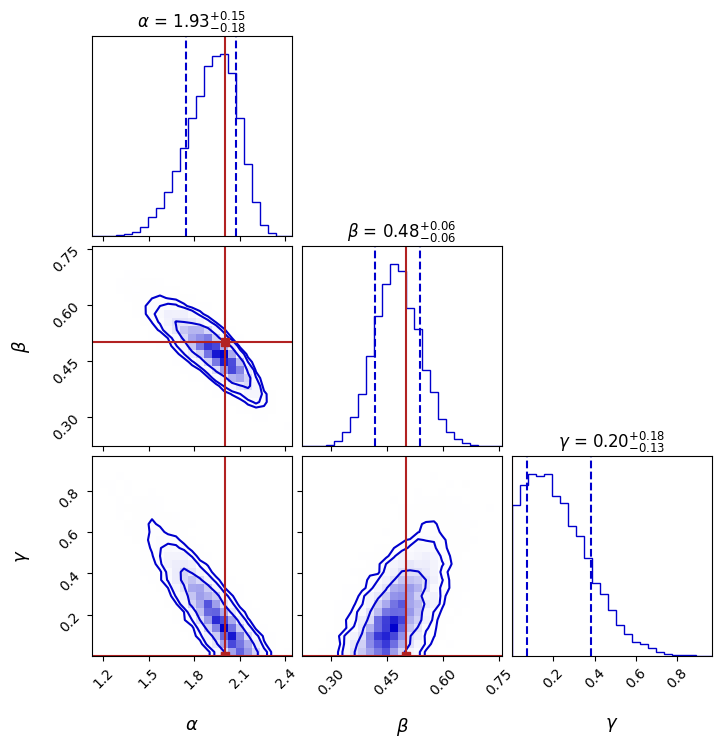

In [81]:
## corner plot of the posterior
## https://matplotlib.org/stable/gallery/color/named_colors.html

labels = [r'$\alpha$',r'$\beta$',r'$\gamma$']
truths = [alpha_true,beta_true,0.]

hist2d_kwargs = {'plot_datapoints':False,'fill_contours':False,
                 'levels':[0.68,0.90,0.95]}

fig = corner.corner(samples,bins=25,color='mediumblue',\
                    truths=truths,truth_color='firebrick',\
                    labels=labels,label_kwargs={'fontsize':13},\
                    quantiles = [0.16,0.84],\
                    show_titles=True,title_quantiles=[0.16,0.5,0.84],\
                    hist_kwargs={'density':True},\
                    **hist2d_kwargs,\
                    )

plt.savefig(PROJECT_PATH+'/plots/corner_%s.pdf'%label,bbox_inches='tight')
plt.show()

In [82]:
## posterior predictive distribution
X = np.linspace(0,1,100)
yp = []
for sample in samples:
  alpha, beta, gamma = sample
  yp.append(alpha*X+beta+gamma*X**2)
yp = np.array(yp)
ylow, ymean, yhigh = np.quantile(yp,q=[0.05,0.5,0.95],axis=0)

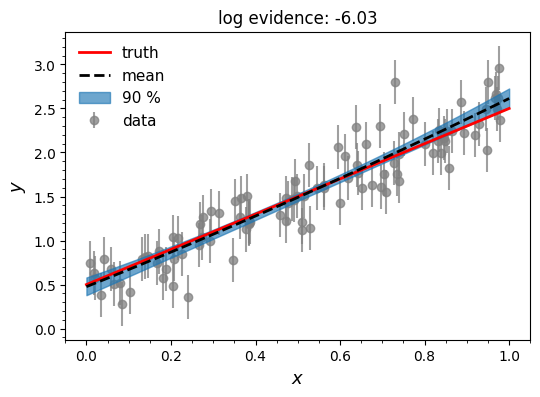

In [83]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.errorbar(x_obs,y_obs,yerr=sigma_y_noise,fmt='o',color='gray',label='data',zorder=-1,alpha=0.75)
axs.plot(X,alpha_true*X+beta_true,color='red',linewidth=2,linestyle='-',label='truth')#,zorder=0)
axs.plot(X,ymean,color='k',linewidth=2,linestyle='--',label='mean')
axs.fill_between(X,ylow,yhigh,color='C0',alpha=0.65,label='90 %')
axs.set_xlabel(r'$x$',fontsize=13)
axs.set_ylabel(r'$y$',fontsize=13)
axs.legend(fontsize=11,frameon=False)
axs.minorticks_on()
axs.set_title('log evidence: %.2f'%res['log_evidence'])
plt.savefig(PROJECT_PATH+'/plots/posterior_%s.pdf'%label,bbox_inches='tight')
plt.show()

In [84]:
## Use the savage dickey ratio to compute the Bayes Factor
kde_gamma = scipy.stats.gaussian_kde(gamma_post)
x_bound = 0.
x = 0.
post_gamma_0 = kde_gamma(x) + kde_gamma(2*x_bound - x)
pre_gamma_0 = 1/5.
log_B_01 = np.log(post_gamma_0) - np.log(pre_gamma_0)
print(log_B_01)

[2.37508915]


Now, we repeat the first experiment but we also estimate the noise level as a free parameter

In [86]:
class SimpleGaussianLikelihood(bilby.Likelihood):
    def __init__(self, x_obs, y_obs):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={"alpha": None,"beta": None,"sigma":None})
        self.x_obs = x_obs
        self.y_obs = y_obs

    def log_likelihood(self):
        alpha = self.parameters["alpha"]
        beta = self.parameters["beta"]
        sigma = self.parameters["sigma"]
        ## LINEAR ANSATZ
        y_pred = alpha*self.x_obs + beta
        out = np.sum(norm.logpdf(y_pred,loc=self.y_obs,scale=sigma))
        return out

In [87]:
likelihood = SimpleGaussianLikelihood(x_obs,y_obs)

In [88]:
priors = dict(
    alpha=bilby.core.prior.Uniform(0, 5, "alpha"),
    beta=bilby.core.prior.Uniform(0, 5, "beta"),
    sigma=bilby.core.prior.Uniform(0, 1, "sigma"),
)
priors

{'alpha': Uniform(minimum=0, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None),
 'beta': Uniform(minimum=0, maximum=5, name='beta', latex_label='beta', unit=None, boundary=None),
 'sigma': Uniform(minimum=0, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)}

In [89]:
outdir = PROJECT_PATH+'/models'
label = 'linear_5k_sigma'

In [90]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=5_000,
    outdir=outdir,
    label=label,
)

11:08 bilby INFO    : Running for label 'linear_5k_sigma', output will be saved to '/content/drive/My Drive/GGI_school_2025/models'
11:08 bilby INFO    : Analysis priors:
11:08 bilby INFO    : alpha=Uniform(minimum=0, maximum=5, name='alpha', latex_label='alpha', unit=None, boundary=None)
11:08 bilby INFO    : beta=Uniform(minimum=0, maximum=5, name='beta', latex_label='beta', unit=None, boundary=None)
11:08 bilby INFO    : sigma=Uniform(minimum=0, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
11:08 bilby INFO    : Analysis likelihood class: <class '__main__.SimpleGaussianLikelihood'>
11:08 bilby INFO    : Analysis likelihood noise evidence: nan
11:08 bilby INFO    : Single likelihood evaluation took 3.255e-04 s
11:08 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 5000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': N

1it [00:00, ?it/s]

11:19 bilby INFO    : Written checkpoint file /content/drive/My Drive/GGI_school_2025/models/linear_5k_sigma_resume.pickle


11:19 bilby INFO    : Rejection sampling nested samples to obtain 16382 posterior samples
11:19 bilby INFO    : Sampling time: 0:10:47.794850
11:19 bilby INFO    : Summary of results:
nsamples: 16382
ln_noise_evidence:    nan
ln_evidence: -6.490 +/-  0.058
ln_bayes_factor:    nan +/-  0.058



In [91]:
outdir = PROJECT_PATH+'/models'
label = 'linear_5k_sigma'

result_file_name = outdir + '/%s_result.json'%label
with open(result_file_name,'r') as f:
  res = json.load(f)

In [92]:
alpha_post = res['posterior']['content']['alpha']
beta_post = res['posterior']['content']['beta']
sigma_post = res['posterior']['content']['sigma']

samples = np.vstack((alpha_post,beta_post,sigma_post)).T
print(samples.shape)

(16382, 3)


In [101]:
## maximum likelihood approxmation
## = ordinary linear least squares

alpha_ml = (np.mean(x_obs*y_obs)-np.mean(x_obs)*np.mean(y_obs))/(np.mean(x_obs**2)-np.mean(x_obs)**2)
beta_ml = np.mean(y_obs)-alpha_ml*np.mean(x_obs)
MSE = np.mean((y_obs-alpha_ml*x_obs-beta)**2)
sigma_ml = np.sqrt(MSE)
sigma_err = sigma_ml/(2*num_obs)**0.5

Gamma = num_obs/(sigma_ml)**2*np.matrix([[np.mean(x_obs**2),np.mean(x_obs)],[np.mean(x_obs),1]])
Sigma = np.array(Gamma.I)

samples_ml = np.random.multivariate_normal(mean=np.array([alpha_ml,beta_ml]),cov=Sigma,size=len(samples))
samples_sigma = np.random.normal(sigma_ml,sigma_err,len(samples))[:,np.newaxis]

samples_ml = np.hstack((samples_ml,samples_sigma))

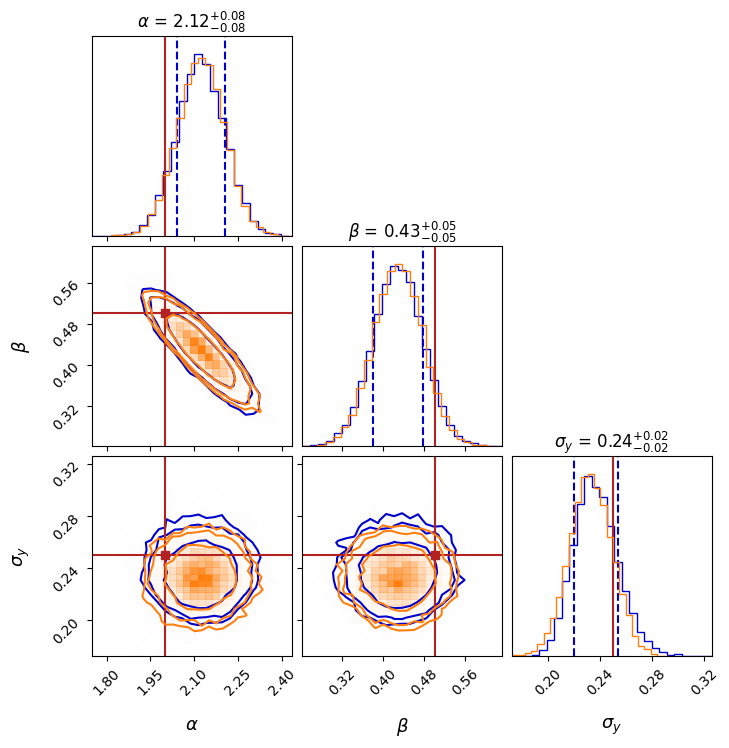

In [104]:
## corner plot of the posterior
## https://matplotlib.org/stable/gallery/color/named_colors.html

labels = [r'$\alpha$',r'$\beta$',r'$\sigma_y$']
truths = [alpha_true,beta_true,sigma_y_noise]

hist2d_kwargs = {'plot_datapoints':False,'fill_contours':False,
                 'levels':[0.68,0.90,0.95]}

fig = corner.corner(samples,bins=25,color='mediumblue',\
                    truths=truths,truth_color='firebrick',\
                    labels=labels,label_kwargs={'fontsize':13},\
                    quantiles = [0.16,0.84],\
                    show_titles=True,title_quantiles=[0.16,0.5,0.84],\
                    hist_kwargs={'density':True},\
                    **hist2d_kwargs,\
                    )

###'''
corner.corner(samples_ml,bins=25,color='C1',\
              labels=None,fig=fig,\
              hist_kwargs={'density':True},\
              **hist2d_kwargs,\
              )
###'''

plt.savefig(PROJECT_PATH+'/plots/corner_%s.pdf'%label,bbox_inches='tight')
plt.show()

# Non-trivial prior on x

In [105]:
from scipy.stats import norm

In [106]:
alpha_true = 2.0
beta_true = 0.5

def model(x):
  return alpha_true*x + beta_true

num_obs = 100

sigma_y_noise = 0.25

In [120]:
x_true = np.random.normal(0.5,0.1,num_obs)
y_true = model(x_true)

x_obs = x_true
zero_noise = True
load=False

if zero_noise:
  y_obs = y_true
elif load==True:
  # load data
  x_obs = np.load(PROJECT_PATH+'/data/x_obs_gauss.npy')
  y_obs = np.load(PROJECT_PATH+'/data/y_obs_gauss.npy')
else:
  y_obs = y_true + np.random.normal(0,sigma_y_noise,num_obs)

In [159]:
class SimpleGaussianLikelihood(bilby.Likelihood):
    def __init__(self, x_obs, y_obs):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={"alpha": None,"beta": None,'mu_x':None,'std_x':None})
        self.x_obs = x_obs
        self.y_obs = y_obs
        self.sigma_y_noise = sigma_y_noise

    def log_likelihood(self):
        alpha = self.parameters["alpha"]
        beta = self.parameters["beta"]
        mu_x = self.parameters["mu_x"]
        std_x = self.parameters["std_x"]
        ## LINEAR ANSATZ
        y_pred = alpha*self.x_obs + beta
        out = np.sum(norm.logpdf(y_pred,loc=self.y_obs,scale=self.sigma_y_noise)+norm.logpdf(self.x_obs,loc=mu_x,scale=std_x))
        return out

In [160]:
likelihood = SimpleGaussianLikelihood(x_obs,y_obs)

In [161]:
priors = dict(
    alpha=bilby.core.prior.Uniform(0, 3, "alpha"),
    beta=bilby.core.prior.Uniform(0, 1, "beta"),
    mu_x=bilby.core.prior.Uniform(0, 1, "mu_x"),
    std_x=bilby.core.prior.Uniform(0, 1, "std_x"),
)
priors

{'alpha': Uniform(minimum=0, maximum=3, name='alpha', latex_label='alpha', unit=None, boundary=None),
 'beta': Uniform(minimum=0, maximum=1, name='beta', latex_label='beta', unit=None, boundary=None),
 'mu_x': Uniform(minimum=0, maximum=1, name='mu_x', latex_label='mu_x', unit=None, boundary=None),
 'std_x': Uniform(minimum=0, maximum=1, name='std_x', latex_label='std_x', unit=None, boundary=None)}

In [162]:
outdir = PROJECT_PATH+'/prova'
label = 'linear_gauss_6'

In [163]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=5_000,
    outdir=outdir,
    label=label,
)

14:02 bilby INFO    : Running for label 'linear_gauss_6', output will be saved to '/content/drive/My Drive/GGI_school_2025/prova'
14:02 bilby INFO    : Analysis priors:
14:02 bilby INFO    : alpha=Uniform(minimum=0, maximum=3, name='alpha', latex_label='alpha', unit=None, boundary=None)
14:02 bilby INFO    : beta=Uniform(minimum=0, maximum=1, name='beta', latex_label='beta', unit=None, boundary=None)
14:02 bilby INFO    : mu_x=Uniform(minimum=0, maximum=1, name='mu_x', latex_label='mu_x', unit=None, boundary=None)
14:02 bilby INFO    : std_x=Uniform(minimum=0, maximum=1, name='std_x', latex_label='std_x', unit=None, boundary=None)
14:02 bilby INFO    : Analysis likelihood class: <class '__main__.SimpleGaussianLikelihood'>
14:02 bilby INFO    : Analysis likelihood noise evidence: nan
14:02 bilby INFO    : Single likelihood evaluation took 3.449e-04 s
14:02 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 5000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflecti

1it [00:00, ?it/s]

14:14 bilby INFO    : Written checkpoint file /content/drive/My Drive/GGI_school_2025/prova/linear_gauss_6_resume.pickle
14:20 bilby INFO    : Written checkpoint file /content/drive/My Drive/GGI_school_2025/prova/linear_gauss_6_resume.pickle
14:20 bilby INFO    : Rejection sampling nested samples to obtain 18579 posterior samples
14:20 bilby INFO    : Sampling time: 0:17:38.811375


14:20 bilby INFO    : Summary of results:
nsamples: 18579
ln_noise_evidence:    nan
ln_evidence: 120.630 +/-  0.060
ln_bayes_factor:    nan +/-  0.060



In [185]:
outdir = PROJECT_PATH+'/prova'
label = 'linear_gauss_6'

result_file_name = outdir + '/%s_result.json'%label
with open(result_file_name,'r') as f:
  res = json.load(f)

In [186]:
alpha_post = res['posterior']['content']['alpha']
beta_post = res['posterior']['content']['beta']
mu_x_post = res['posterior']['content']['mu_x']
std_x_post = res['posterior']['content']['std_x']

#samples = np.vstack((alpha_post,beta_post)).T
samples = np.vstack((alpha_post,beta_post,mu_x_post,std_x_post)).T
print(samples.shape)

(18579, 4)


In [213]:
## maximum likelihood approxmation
## = ordinary linear least squares

alpha_ml = (np.mean(x_obs*y_obs)-np.mean(x_obs)*np.mean(y_obs))/(np.mean(x_obs**2)-np.mean(x_obs)**2)
beta_ml = np.mean(y_obs)-alpha_ml*np.mean(x_obs)

Gamma = num_obs/(sigma_y_noise)**2*np.matrix([[np.mean(x_obs**2),np.mean(x_obs)],[np.mean(x_obs),1]])
Sigma = np.array(Gamma.I)

samples_ml = np.random.multivariate_normal(mean=np.array([alpha_ml,beta_ml]),cov=Sigma,size=len(samples))

mu_x_ml = np.mean(x_obs)
std_x_ml = np.std(x_obs)

samples_mu_x = np.random.normal(mu_x_ml,std_x_ml/(num_obs)**0.5,len(samples))#[:,np.newaxis]
samples_std_x = np.random.normal(std_x_ml,std_x_ml/(2*num_obs)**0.5,len(samples))#[:,np.newaxis]

samples_ml = np.vstack((*samples_ml.T,samples_mu_x,samples_std_x)).T

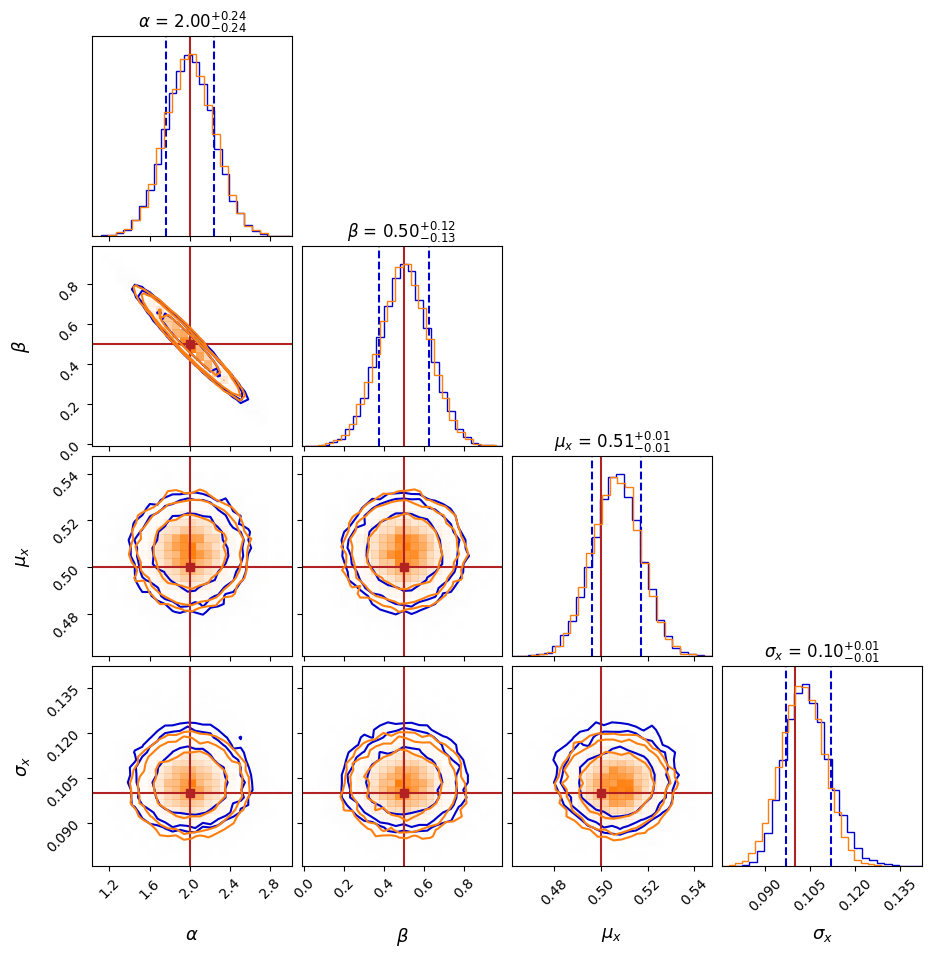

In [214]:
## corner plot of the posterior
## https://matplotlib.org/stable/gallery/color/named_colors.html

labels = [r'$\alpha$',r'$\beta$',r'$\mu_x$',r'$\sigma_x$']
truths = [alpha_true,beta_true,0.5,0.1]

hist2d_kwargs = {'plot_datapoints':False,'fill_contours':False,
                 'levels':[0.68,0.90,0.95]}

fig = corner.corner(samples,bins=25,color='mediumblue',\
                    truths=truths,truth_color='firebrick',\
                    labels=labels,label_kwargs={'fontsize':13},\
                    quantiles = [0.16,0.84],\
                    show_titles=True,title_quantiles=[0.16,0.5,0.84],\
                    hist_kwargs={'density':True},\
                    **hist2d_kwargs,\
                    )

###'''
corner.corner(samples_ml,bins=25,color='C1',\
              labels=None,fig=fig,\
              hist_kwargs={'density':True},\
              **hist2d_kwargs,\
              )
###'''

#plt.savefig(PROJECT_PATH+'/plots/corner_%s.pdf'%label,bbox_inches='tight')
plt.show()

In [215]:
## posterior predictive distribution
X = np.linspace(0,1,100)
yp = []
for sample in samples:
  alpha, beta, _, _ = sample
  yp.append(alpha*X+beta)
yp = np.array(yp)
ylow, ymean, yhigh = np.quantile(yp,q=[0.05,0.5,0.95],axis=0)

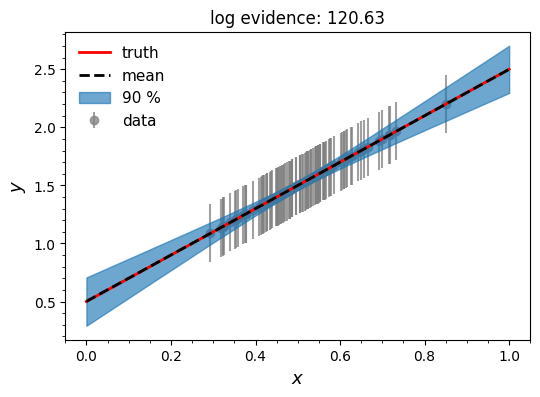

In [216]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.errorbar(x_obs,y_obs,yerr=sigma_y_noise,fmt='o',color='gray',label='data',zorder=-1,alpha=0.75)
axs.plot(X,alpha_true*X+beta_true,color='red',linewidth=2,linestyle='-',label='truth')#,zorder=0)
axs.plot(X,ymean,color='k',linewidth=2,linestyle='--',label='mean')
axs.fill_between(X,ylow,yhigh,color='C0',alpha=0.65,label='90 %')
axs.set_xlabel(r'$x$',fontsize=13)
axs.set_ylabel(r'$y$',fontsize=13)
axs.legend(fontsize=11,frameon=False)
axs.minorticks_on()
axs.set_title('log evidence: %.2f'%res['log_evidence'])
#plt.savefig(PROJECT_PATH+'/plots/posterior_%s.pdf'%label,bbox_inches='tight')
plt.show()

In [218]:
a = np.linspace(0,1,100)
a.std(), a.mean()

(0.29157646512850627, 0.5)